# How to run this notebook

1. Download all-full.csv, container.csv and model1 from google drive
2. Upper left corner > Runtime > run all
3. Go into first cell and choose to upload the three files. This will take a minute.
4. Wait for all cells to complete running. Cells are competed when there is no spinning run button.

## Set up

In [ ]:
from google.colab import files
# choose to upload all-full.csv and container.csv and model1
uploaded = files.upload()
%ls


Saving all-full.csv to all-full.csv
Saving container.csv to container.csv
Saving model1 to model1
all-full.csv  container.csv  model1  sample_data/


In [ ]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
import numpy as np
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
model_google_news = api.load("word2vec-google-news-300")
model_fasttext_wiki_news_subwords = api.load("fasttext-wiki-news-subwords-300")


In [ ]:
def load_logistic_regression_data():
  text = np.genfromtxt('container.csv', delimiter=",", dtype=None, encoding=None)
  labels = np.genfromtxt('all-full.csv', delimiter=",", usecols=0, skip_header=1)
  w2v = gensim.models.word2vec.Word2Vec.load('model1') 
  return text, labels, w2v.wv

In [ ]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v.vocab]
    return np.mean(w2v[doc], axis=0)

def document_vector_news(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in model_google_news.vocab]
    return np.mean(model_google_news[doc], axis=0)

In [ ]:
# load data & model
text, label, w2v = load_logistic_regression_data()

# split data in to test & train
train, test, label_train, label_test = train_test_split(text, label, test_size=0.2)

# setup w2v word matrices
w2v_train = []
w2v_test = []
for t in train:
  w2v_train.append(document_vector(t))
for t in test:
  w2v_test.append(document_vector(t))

# setup w2v word matrices
w2v_train_news = []
w2v_test_news = []
for t in train:
  w2v_train_news.append(document_vector_news(t))
for t in test:
  w2v_test_news.append(document_vector_news(t))

# setup sklearn count matrices
vectorizer = CountVectorizer(min_df=10)
X_train = vectorizer.fit_transform(train)
X_test = vectorizer.transform(test)


## Model training

### Count vectorization

#### Logistic regression model using count vectorization

In [ ]:
# Fit to logistic regression using count vectors
# cross validation of lambda values (regularization strength)

lambda_val = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
lrcv = sklearn.linear_model.LogisticRegressionCV(penalty="l2", Cs=lambda_val, cv=5)
lrcv.fit(X_train, label_train)

y_lrcv_pred = lrcv.predict(X_test)
lr_accuracy = metrics.accuracy_score(label_test, y_lrcv_pred)

#### Random Forst classifier using count vectorization

In [ ]:
# Fit to random forest using count vectors
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, label_train)

y_rf_pred = clf.predict(X_test)
rf_accu = metrics.accuracy_score(label_test, y_rf_pred)

### Word2Vec Vectorization

#### Logistic regression model using word2vec vectorization

In [ ]:
# Fit to logistic regression using w2v matrices
lambda_val = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
lrcv_w2v = sklearn.linear_model.LogisticRegressionCV(penalty="l2", Cs=lambda_val, cv=5)
lrcv_w2v.fit(w2v_train, label_train)

y_lrcvw_pred = lrcv_w2v.predict(w2v_test)
lrw_accuracy = metrics.accuracy_score(label_test, y_lrcvw_pred)

In [ ]:
# Fit to logistic regression using w2v matrices
lambda_val = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
lrcv_w2v_news = sklearn.linear_model.LogisticRegressionCV(penalty="l2", Cs=lambda_val, cv=5)
lrcv_w2v_news.fit(w2v_train_news, label_train)

y_lrcvw_news_pred = lrcv_w2v_news.predict(w2v_test_news)
lrw_news_accuracy = metrics.accuracy_score(label_test, y_lrcvw_news_pred)

#### Random Forest classifier using word2vec vectorization

In [ ]:
# Fit to random forest using w2v vectors
clf_w2v = RandomForestClassifier(n_estimators=100)
clf_w2v.fit(w2v_train, label_train)

y_wrf_pred = clf_w2v.predict(w2v_test)
rfw_accu = metrics.accuracy_score(label_test, y_wrf_pred)

In [ ]:
# Fit to random forest using w2v vectors
clf_w2v_news = RandomForestClassifier(n_estimators=100)
clf_w2v_news.fit(w2v_train_news, label_train)

y_wrf_news_pred = clf_w2v_news.predict(w2v_test_news)
rfw_news_accu = metrics.accuracy_score(label_test, y_wrf_news_pred)

### Dummy Model (zero rule)

In [ ]:
# Fit to dummy (zero rule) classifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, label_train)

y_dummy_pred = dummy.predict(X_test)
dummy_accu = metrics.accuracy_score(label_test, y_dummy_pred)

## Visualization of models

In [ ]:
print("Accuracies:")
print("Logistic Regression with count vec:", lr_accuracy)
print("Logistic Regression with word2vec own corpus:", lrw_accuracy)
print("Logistic Regression with word2vec news corpus:", lrw_news_accuracy)
print()
print("Random Forest with count vec:", rf_accu)
print("Random Forest with with word2vec own corpus:", rfw_accu)
print("Random Forest with with word2vec news corpus:", rfw_news_accu)

Accuracies:
Logistic Regression with count vec: 0.8692307692307693
Logistic Regression with word2vec own corpus: 0.5365384615384615
Logistic Regression with word2vec news corpus: 0.6730769230769231

Random Forest with count vec: 0.8615384615384616
Random Forest with with word2vec own corpus: 0.6961538461538461
Random Forest with with word2vec news corpus: 0.7346153846153847


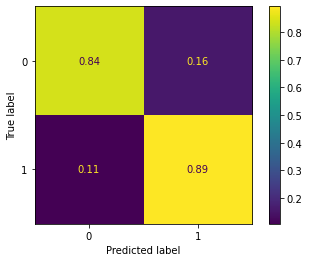

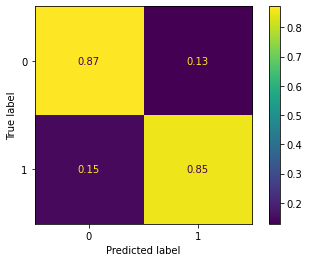

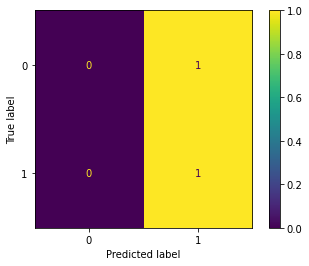

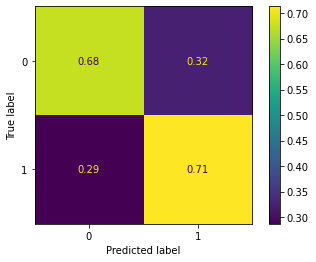

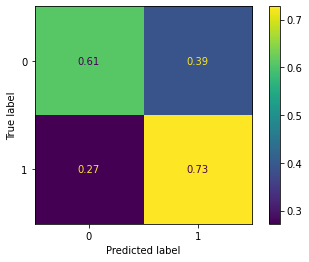

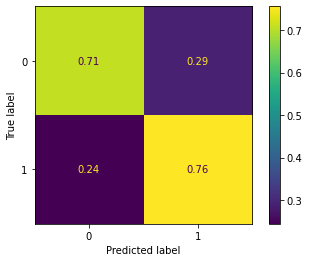

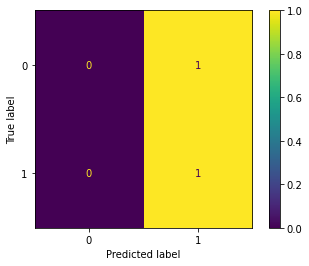

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lrcv, X_test, label_test, normalize='true', display_labels=[0, 1])
plot_confusion_matrix(clf, X_test, label_test, normalize='true', display_labels=[0, 1])
plot_confusion_matrix(lrcv_w2v, w2v_test, label_test, normalize='true', display_labels=[0, 1])
plot_confusion_matrix(clf_w2v, w2v_test, label_test, normalize='true', display_labels=[0, 1])
plot_confusion_matrix(lrcv_w2v_news, w2v_test_news, label_test, normalize='true', display_labels=[0, 1])
plot_confusion_matrix(clf_w2v_news, w2v_test_news, label_test, normalize='true', display_labels=[0, 1])
plot_confusion_matrix(dummy, X_test, label_test, normalize='true', display_labels=[0, 1])
plt.show()

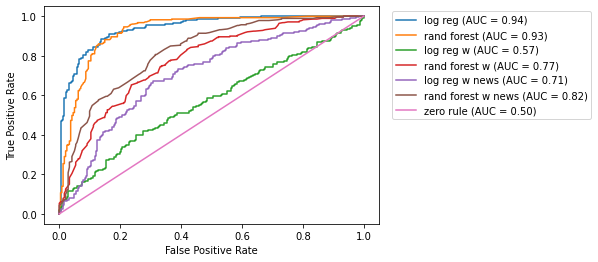

In [ ]:
lrcv_roc = metrics.plot_roc_curve(lrcv, X_test, label_test, name="log reg")
clf_roc = metrics.plot_roc_curve(clf, X_test, label_test, name="rand forest", ax=lrcv_roc.ax_)
lrcvw_roc = metrics.plot_roc_curve(lrcv_w2v, w2v_test, label_test, name="log reg w", ax=lrcv_roc.ax_)
clfw_roc = metrics.plot_roc_curve(clf_w2v, w2v_test, label_test, name="rand forest w", ax=lrcv_roc.ax_)
lrcvw_news_roc = metrics.plot_roc_curve(lrcv_w2v_news, w2v_test_news, label_test, name="log reg w news", ax=lrcv_roc.ax_)
clfw_news_roc = metrics.plot_roc_curve(clf_w2v_news, w2v_test_news, label_test, name="rand forest w news", ax=lrcv_roc.ax_)
dum_roc = metrics.plot_roc_curve(dummy, X_test, label_test, name="zero rule", ax=lrcv_roc.ax_)
plt.legend(loc="upper right", bbox_to_anchor=(1.65, 1))
plt.show()


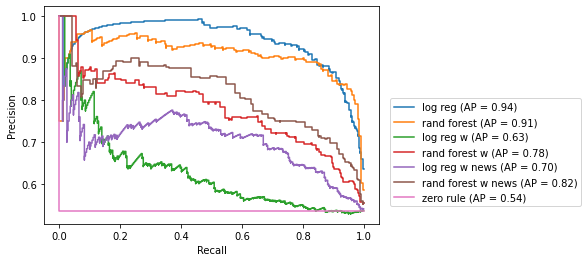

In [ ]:
lrcv_pc = metrics.plot_precision_recall_curve(lrcv, X_test, label_test, name="log reg")
clf_pc = metrics.plot_precision_recall_curve(clf, X_test, label_test, name="rand forest", ax=lrcv_pc.ax_)
lrcvw_pc = metrics.plot_precision_recall_curve(lrcv_w2v, w2v_test, label_test, name="log reg w", ax=lrcv_pc.ax_)
clfw_pc = metrics.plot_precision_recall_curve(clf_w2v, w2v_test, label_test, name="rand forest w", ax=lrcv_pc.ax_)
lrcvw_news_pc = metrics.plot_precision_recall_curve(lrcv_w2v_news, w2v_test_news, label_test, name="log reg w news", ax=lrcv_pc.ax_)
clfw_news_pc = metrics.plot_precision_recall_curve(clf_w2v_news, w2v_test_news, label_test, name="rand forest w news", ax=lrcv_pc.ax_)
dum_pc = metrics.plot_precision_recall_curve(dummy, X_test, label_test, name="zero rule", ax=lrcv_pc.ax_)
plt.legend(loc="upper right", bbox_to_anchor=(1.62, 0.6))
plt.show()